# Implementación matricial del algoritmo K-NN usando Pytorch.

## Imports

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np;
import pandas as pandas;
from scipy import ndimage
from torchvision import datasets, transforms
from torch.distributions import normal
from torch.distributions import multivariate_normal
import matplotlib.pyplot as plt
import time
# torch.set_printoptions(profile="full") # descomentar para ver todos los datos en el print.
from sklearn.model_selection import train_test_split

### Implementation of Euclidean Distance.

In [ ]:
def cal_euclidean_distance(x, data, observ):
  # Obtain the value from training data.
  neighbor = data[x]

  # Calculate the distance.
  difference = (neighbor - observ)
  difference = difference**2
  difference = difference.sum()
  distance = torch.sqrt(difference)
  # Return the distance.
  return distance

### Implementation of Manhattan Distance.

In [ ]:
def cal_manhattan_distance(x, data, observ):
  # Obtain the value from training data.
  neighbor = data[x]

  # Calculate the distance.
  distance = torch.sum(torch.abs(neighbor - observ))
  # Return the distance.
  return distance

### Scripts for testing

In [ ]:
print("Distancia euclidiana:", cal_euclidean_distance(0, torch.tensor([[3,5], [4, 6]]), torch.tensor([2, 4])))
print("Distancia Manhattan:", cal_manhattan_distance(0, torch.tensor([[3,5], [4, 6]]), torch.tensor([2, 4])))

Distancia euclidiana: tensor(1.4142)
Distancia Manhattan: tensor(2)


### Get a label based in an observation using KNN.

In [ ]:
def evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, K = 3, is_euclidian = True):

  # Generar una lista con los indices del dataset.
  indexs = list(range(0, len(data_training), 1))
  distances = torch.tensor(indexs)
  # Aplicar la distancia euclidiana o manhattan a cada indice del dataset.
  if is_euclidian:
    # Calcular distancia euclidiana
    distances = distances.apply_(lambda x: cal_euclidean_distance(x, data_training, test_observation))
  else:
    # Calcular distancia manhattan.
    distances = distances.apply_(lambda x: cal_manhattan_distance(x, data_training, test_observation))

  # Cambiar la orientación de la lista de vector fila a vector columna.
  distances = distances.reshape(-1,1)

  # Concatenar las distancias con los labels.
  distances = torch.cat((distances, labels_training), 1)

  # Ordenar las distancias.
  distances_sorted = distances[distances[:, 0].sort()[1]]

  # Seleccionar los K vecinos más cercanos.
  neighbors = distances_sorted[:K, 1]

  # Evaluar si es 0 o 1, la etiqueta final.
  if(torch.sum(neighbors) >= K//2 + 1):
    return 1
  else:
    return 0


### Testing script for ``` evaluate_k_nearest_neighbors_observation ```



In [ ]:
data_training  = torch.tensor([[4, 5], [6, 7], [5,6], [5, 7], [3, 5], [3, 4]])
labels_training = torch.tensor([0, 1, 1, 1, 0, 0])

labels_training = labels_training.reshape(-1, 1)
observ = torch.tensor([5,5])
res = evaluate_k_nearest_neighbors_observation(data_training, labels_training, observ, 3, True)
print("Prediccion", res)

Prediccion 1


In [ ]:
def evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, test_dataset, K = 3, is_euclidian = True):
    # Lista final de labels predecidos.
    list_labels = []
    # Predecir cada observación.
    for obser in test_dataset:
      label = evaluate_k_nearest_neighbors_observation(data_training, labels_training, obser, K, is_euclidian)
      list_labels.append(label)
    # Convertir a vector fila.
    labels = torch.tensor(list_labels).reshape(-1, 1)
    return labels

In [ ]:
def calculate_hit_rate(estimates, labels):
  # Comparar cada fila para saber si son iguales.
  labels_eq = torch.eq(estimates, labels)

  # Convertir los booleanos a enteros.
  labels_eq = labels_eq.bool().int()

  # Sumar todos.
  total_hits = torch.sum(labels_eq)


  # Calcular la cantidad de aciertos, para ellos se saca la cantidad de iguales y se divide entre el tamaño de la muestra.
  hit_rate = total_hits / len(estimates)

  return hit_rate * 100

## Artificial dataset


In [ ]:
  # Creates the data to be used for training, using a GMM distribution
'''
@param numberSamplesPerClass, the number of samples per class
@param mean1, means for samples from the class 1
@param mean2, means for samples from the class 2
@param stds1, standard deviation for samples, class 1
@param stds2, standard deviation for samples, class 2
'''

def createData(numberSamplesPerClass = 2000, mean1 = [12, 12], mean2 = [15, 15], stds1 = [3, 3], stds2 = [2, 2]):
    means = torch.zeros(2)

    # Ones to concatenate for bias
    ones = torch.ones(numberSamplesPerClass, 1)
    means[0] = mean1[0]
    means[1] = mean1[1]

    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds1[0]
    covarianceMatrix[1, 1] = stds1[1]

    samplesClass1 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)
    means[0] = mean2[0]
    means[1] = mean2[1]
    covarianceMatrix[0, 0] = stds2[0]
    covarianceMatrix[1, 1] = stds2[1]

    samplesClass2 = createDataOneClass(means, covarianceMatrix, numberSamplesPerClass)


    # Concatenates the ones for the bias
    samplesClass1Bias = torch.cat((ones, samplesClass1), 1)
    samplesClass2Bias = torch.cat((ones, samplesClass2), 1)
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)

    plt.scatter(samplesClass1[:, 0], samplesClass1[:, 1])
    plt.scatter(samplesClass2[:, 0], samplesClass2[:, 1], marker = 'x')
    plt.title("Scatter plot from Dataset generated")
    plt.show()

    #Create samples without bias
    samplesAll = torch.cat((samplesClass1, samplesClass2), 0)

    #Create targets
    targetsClass1 = torch.ones(numberSamplesPerClass, 1)
    targetsClass2 = torch.zeros(numberSamplesPerClass, 1)
    targetsAll = torch.cat((targetsClass1, targetsClass2), 0)

    return (targetsAll, samplesAll)

# Creates data with gaussian distribution
def createDataOneClass(means, covarianceMatrix, numberSamples):

    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)

    # Takes the samples
    samples = multiGaussGenerator.sample(torch.Size([numberSamples]))

    return samples

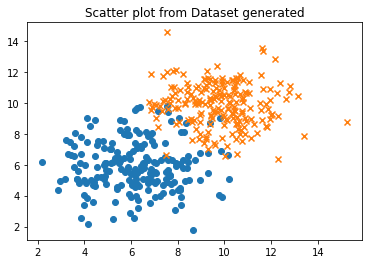

tensor([6.2165, 8.2615])


In [ ]:
(all_labels, all_samples) = createData(numberSamplesPerClass = 200, mean1 = [6,6], mean2 = [10, 10], stds1 = [3, 3], stds2 = [2, 2])
print(all_samples[0])

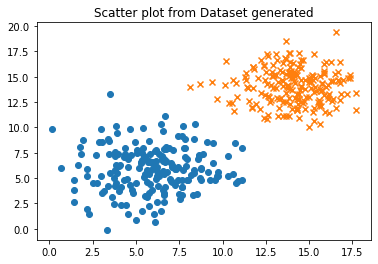

In [ ]:
(all_labels, all_samples) = createData(numberSamplesPerClass = 200, mean1 = [6,6], mean2 = [14, 14], stds1 = [5, 5], stds2 = [3, 3])

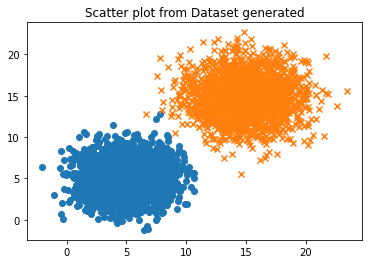

In [ ]:
(all_labels_3, all_samples_3) = createData(numberSamplesPerClass = 2000, mean1 = [5,5], mean2 = [15, 15], stds1 = [4, 4], stds2 = [6, 6])

## Comparar la tasa de aciertos de las distancias Manhattan y Euclidiana usando los datasets anteriores y K=7.

### Medias cercanas

In [ ]:
predicted_euclidian = evaluate_k_nearest_neighbors_test_dataset(all_samples, all_labels, all_samples,  is_euclidian = True)
print("Hit rate Distancia Euclidiana: ", calculate_hit_rate(predicted_euclidian, all_labels))

Hit rate Distancia Euclidiana:  tensor(89.4750)


In [ ]:
predicted_manhattan = evaluate_k_nearest_neighbors_test_dataset(all_samples, all_labels, all_samples,  is_euclidian = False)
print("Hit rate Distancia Manhattan: ", calculate_hit_rate(predicted_manhattan, all_labels))

Hit rate Distancia Manhattan:  tensor(90.3250)


### Medias lejanas

In [ ]:
predicted_euclidian = evaluate_k_nearest_neighbors_test_dataset(all_samples_2, all_labels_2, all_samples_2,  is_euclidian = True)
print("Hit rate Distancia Euclidiana: ", calculate_hit_rate(predicted_euclidian, all_labels_2))

Hit rate Distancia Euclidiana:  tensor(100.)


In [ ]:
predicted_manhattan = evaluate_k_nearest_neighbors_test_dataset(all_samples_2, all_labels_2, all_samples_2,  is_euclidian = False)
print("Hit rate Distancia Manhattan: ", calculate_hit_rate(predicted_manhattan, all_labels_2))

Hit rate Distancia Manhattan:  tensor(100.)


### Medias lejanas con mayor desviación estándar

In [ ]:
predicted_euclidian = evaluate_k_nearest_neighbors_test_dataset(all_samples_3, all_labels_3, all_samples_3,  is_euclidian = True)
print("Hit rate Distancia Euclidiana: ", calculate_hit_rate(predicted_euclidian, all_labels_3))

Hit rate Distancia Euclidiana:  tensor(99.9250)


In [ ]:
predicted_manhattan = evaluate_k_nearest_neighbors_test_dataset(all_samples_3, all_labels_3, all_samples_3,  is_euclidian = False)
print("Hit rate Distancia Manhattan: ", calculate_hit_rate(predicted_manhattan, all_labels_3))

Hit rate Distancia Manhattan:  tensor(99.9500)


# Prueba con datos segmentados.

In [ ]:
# Listas para guardar los hit rates de cada una de las pruebas para las distancias.
hit_rate_euList = []
hit_rate_mathList = []


for i in range(1, 11):

  print("Ejecución: %s" % (i))
  # Separamos el dataset en train (70%) y test (30%).
  X_train, X_test, y_train, y_test = train_test_split(all_samples, all_labels, test_size=0.30, random_state=42)

   # Inicio ejecución distancia Euclidiana.
  start_time = time.time()
  # Calcular labels:
  labels_predict = evaluate_k_nearest_neighbors_test_dataset(X_train, y_train, X_test,  is_euclidian = True)
  # Calcular hit rate.
  hit_rate = calculate_hit_rate(labels_predict, y_test)
  hit_rate_euList.append(hit_rate)
  # Fin ejecución distancia Euclidiana.
  time_exc = time.time() - start_time
  #  Imprimir datos.
  print("Datos distancia Euclidiana: ")
  print("Hit rate", hit_rate)
  print("Tiempo de ejecución: ", time_exc)

  # Inicio ejecución distancia Manhattan.
  start_time = time.time()
  # Calcular labels:
  labels_predict = evaluate_k_nearest_neighbors_test_dataset(X_train, y_train, X_test,  is_euclidian = False)
  # Calcular hit rate.
  hit_rate = calculate_hit_rate(labels_predict, y_test)
  hit_rate_mathList.append(hit_rate)
  # Fin ejecución distancia Manhattan.
  time_exc = time.time() - start_time
  #  Imprimir datos.
  print("Datos distancia manhattan: ")
  print("Hit rate", hit_rate)
  print("Tiempo de ejecución: ", time_exc)

Ejecución: 1
Datos distancia Euclidiana: 
Hit rate tensor(89.5000)
Tiempo de ejecución:  56.41367244720459
Datos distancia manhattan: 
Hit rate tensor(88.8333)
Tiempo de ejecución:  43.628005027770996
Ejecución: 2
Datos distancia Euclidiana: 
Hit rate tensor(89.5000)
Tiempo de ejecución:  56.50300717353821
Datos distancia manhattan: 
Hit rate tensor(88.8333)
Tiempo de ejecución:  43.52546286582947
Ejecución: 3
Datos distancia Euclidiana: 
Hit rate tensor(89.5000)
Tiempo de ejecución:  56.41393446922302
Datos distancia manhattan: 
Hit rate tensor(88.8333)
Tiempo de ejecución:  43.51092720031738
Ejecución: 4
Datos distancia Euclidiana: 
Hit rate tensor(89.5000)
Tiempo de ejecución:  56.472936153411865
Datos distancia manhattan: 
Hit rate tensor(88.8333)
Tiempo de ejecución:  43.50253891944885
Ejecución: 5
Datos distancia Euclidiana: 
Hit rate tensor(89.5000)
Tiempo de ejecución:  56.411362409591675
Datos distancia manhattan: 
Hit rate tensor(88.8333)
Tiempo de ejecución:  43.657872438430

## Medias y desviación estándar de hit rate

### Distancia euclidiana

In [ ]:
eu_std = torch.std(torch.tensor(hit_rate_euList))
print("Desviación estándar", mt_std)

eu_mean = torch.mean(torch.tensor(hit_rate_euList))
print("Media", eu_mean)

Desviación estándar tensor(8.0421e-06)
Desviación estándar tensor(89.5000)


# Distancia Manhattan

In [ ]:
mt_std = torch.std(torch.tensor(hit_rate_mathList))
print("Desviación estándar", mt_std)

mt_mean = torch.mean(torch.tensor(hit_rate_mathList))
print("Media", mt_mean)

Desviación estándar tensor(8.0421e-06)
Desviación estándar tensor(88.8333)
